#Dataset Loading

In [ ]:
import pandas as pd

In [ ]:
ds_name = "shakespeare_back_translated.csv"
path= F"/content/gdrive/My Drive/Database/{ds_name}"
ds = pd.read_csv(path)

In [ ]:
original = ds['original']

back = ds['back_translated']


In [ ]:
print(len(original))

22263


In [ ]:
print(original[10])
print(back[10])

upon the wounds his body bears , which show
on the wounds his body bears that you see


In [ ]:
import sklearn
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf

# Seq2Seq Data_preprocess

In [ ]:
class Preprocess_seq2seq:
  def __init__(self, vocab):
    self.vocab = vocab


  def preprocess_sentence(self, w):
    import re
    # Lower
    w = w.lower().strip()
    w = '<START> ' + w + ' <END>'

    # creating a space between a word and the punctuation following it
    w = re.sub(r"([?.,!¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)

    # outputting the (Glove)voca b values
    w = w.split()
    w = [word if word in self.vocab else '<UNK>' for word in w]
    Out = [self.vocab[word] for word in w]

    return Out


  def create_dataset(self, input, target, max_len, test_size, buffer_size, batch_size):
    Input = np.array([self.preprocess_sentence(w) for w in input])
    Target = np.array([self.preprocess_sentence(w) for w in target])

    # padding
    Input = tf.keras.preprocessing.sequence.pad_sequences(Input, maxlen= max_len, padding='post')
    Target = tf.keras.preprocessing.sequence.pad_sequences(Target, maxlen= max_len, padding='post')

    input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(Input, Target, test_size= test_size)
    train_dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train))
    train_dataset = train_dataset.shuffle(buffer_size).batch(batch_size, drop_remainder=True)

    val_dataset = tf.data.Dataset.from_tensor_slices((input_tensor_val, target_tensor_val))
    val_dataset = val_dataset.batch(batch_size, drop_remainder=True)

    return train_dataset, val_dataset



In [ ]:
buffer_size = 22000
batch_size = 64
max_len = 17
test_size = 0.04

preprocess = Preprocess_seq2seq(vocab)
train_dataset, val_dataset = preprocess.create_dataset(original, back, max_len, test_size, buffer_size, batch_size)

<ipython-input-54-8288e5693e1a>:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Input = np.array([self.preprocess_sentence(w) for w in input])
<ipython-input-54-8288e5693e1a>:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Target = np.array([self.preprocess_sentence(w) for w in target])


In [ ]:
# Testing the Example Batches
example_input_batch, example_target_batch = next(iter(train_dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 17]), TensorShape([64, 17]))

In [ ]:
print(type(example_input_batch[: , 3]))

<class 'tensorflow.python.framework.ops.EagerTensor'>


# google drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# downloading Glove

In [ ]:
# Loading Glove
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

glove_path = 'glove.6B.100d.txt'


--2023-10-01 22:32:08--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-10-01 22:32:08--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-10-01 22:32:08--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
import numpy as np
embedding_dim = 100
embedding_matrix = {}

with open(glove_path, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_matrix[word] = coefs

# Embedding matrix

vocab = {'<PAD>': 0, '<UNK>': 1, '<START>': 2, '<END>': 3}
for word in embedding_matrix.keys():
    vocab[word] = len(vocab)

vocab_size = len(vocab)
embedding_matrix['<PAD>'] = np.zeros(embedding_dim)  # Padding token
embedding_matrix['<UNK>'] = np.random.randn(embedding_dim)  # Unknown token
embedding_matrix['<START>'] = np.random.randn(embedding_dim)  # START token
embedding_matrix['<END>'] = np.random.randn(embedding_dim)  # END token

embedding_matrix = np.array([embedding_matrix[word] for word in vocab])

# Saving the embeddding matrix
matrix_name = "Glove_embedding_matrix.npy"
path= F"/content/gdrive/My Drive/matrices/{matrix_name}"

np.save(path, embedding_matrix)

FileNotFoundError: ignored

In [ ]:
import pickle
vpath = "/content/gdrive/My Drive/matrices/vocab.pkl"
with open(vpath, 'wb') as file:
    pickle.dump(vocab, file)

In [ ]:
print(np.shape(embedding_matrix))

# Loading Embedding_matrix & Vocab

In [ ]:
import numpy as np
import pickle

# Read dictionary pkl file
with open("/content/gdrive/My Drive/matrices/vocab.pkl", 'rb') as fp:
    vocab= pickle.load(fp)

matrix_name = "Glove_embedding_matrix.npy"
path= F"/content/gdrive/My Drive/matrices/{matrix_name}"

embedding_matrix = np.load(path)

In [ ]:
emb_empathy = embedding_matrix[vocab['empathy']]
print(np.shape(emb_empathy))

(100,)


In [ ]:
vocab_size = len(vocab)
embedding_dim = 100

In [ ]:
import tensorflow as tf

embedding_layer = tf.keras.layers.Embedding(
    input_dim=vocab_size,
    output_dim=embedding_dim,
    weights=[embedding_matrix],
    trainable=False
)

sequence_input = tf.keras.layers.Input(shape=(10,))
embedded_sequences = embedding_layer(sequence_input)
emb_model = tf.keras.models.Model(inputs=sequence_input, outputs= embedded_sequences)

In [ ]:
s = 'i come home'
s = str.split(s)
s = np.array([vocab[i] for i in s])
emb_pred = emb_model(s)

In [ ]:
print(np.shape(emb_pred))
if np.all(emb_pred[0] - embedding_matrix[vocab['i']]) == 0:
  print('same')

(3, 100)
same


In [ ]:
print(np.shape(embedding_matrix))

(400004, 100)


# Encoder

In [ ]:
# Encoder class

class Encoder(tf.keras.Model):
  def __init__(self, units, batch_size, trainable=False, mask_zero=True, dropout=0.2, recurrent_dropout=0.1):
    super(Encoder, self).__init__()
    self.batch_size = batch_size
    self.units = units

    self.embedding_layer = tf.keras.layers.Embedding(
    input_dim=vocab_size,
    output_dim=embedding_dim,
    weights=[embedding_matrix],
    mask_zero=mask_zero,
    trainable=trainable)

    self.lstm_layer = tf.keras.layers.Bidirectional(
    tf.keras.layers.LSTM(self.units, return_sequences=True, return_state=True,
                         dropout=dropout, recurrent_dropout=recurrent_dropout))

  def call(self, x, hidden):
    x = self.embedding_layer(x)

    output, forward_h, forward_c, backward_h, backward_c = self.lstm_layer(x, initial_state = hidden)
    # concatenate the forward and backward hidden states
    state_h = tf.concat([forward_h, backward_h], axis=-1)
    # concatenate the forward and backward cell states
    state_c = tf.concat([forward_c, backward_c], axis=-1)
    return output, state_h, state_c

  def initialize_hidden_state(self):
      return [tf.zeros((self.batch_size, self.units)), tf.zeros((self.batch_size, self.units)),tf.zeros((self.batch_size, self.units)),tf.zeros((self.batch_size, self.units))]

In [ ]:
# Testing Encoder

enc = Encoder(100, 64)
x = example_target_batch
initial = enc.initialize_hidden_state()

output, enc_h, enc_c = enc.call(x, initial)
print('out, h, c: ', np.shape(output),' ',np.shape(enc_h),' ',np.shape(enc_c))

out, h, c:  (64, 17, 200)   (64, 200)   (64, 200)


## Encoder_with_model

In [ ]:
import tensorflow as tf

class Encoder_with_model(tf.keras.Model):
    def __init__(self, units, batch_size, trainable=True, mask_zero=True):
        super(Encoder_with_model, self).__init__()
        self.batch_size = batch_size
        self.units = units

        self.embedding_layer = tf.keras.layers.Embedding(
            input_dim=vocab_size,
            output_dim=embedding_dim,
            weights=[embedding_matrix],
            mask_zero=mask_zero,
            trainable=trainable)

        self.lstm_layer = tf.keras.layers.Bidirectional(
            tf.keras.layers.LSTM(self.units, return_sequences=True, return_state=True))

    def build_model(self, initial=None):
        if initial == None:
          initial = self.initialize_hidden_state()
        inputs = tf.keras.Input(shape=(None,))
        hidden = self.initialize_hidden_state()
        x = self.embedding_layer(inputs)
        output, forward_h, forward_c, backward_h, backward_c = self.lstm_layer(x, initial_state=initial)
        state_h = tf.concat([forward_h, backward_h], axis=-1)
        state_c = tf.concat([forward_c, backward_c], axis=-1)
        model = tf.keras.Model(inputs, [output, state_h, state_c])
        return model

    def call(self, input_sequences, initial = None):
        if initial == None:
          initial = self.initialize_hidden_state()
        model = self.build_model(initial)
        results = model(input_sequences)
        return model, results

    def initialize_hidden_state(self):
        return [
            tf.zeros((self.batch_size, self.units)),
            tf.zeros((self.batch_size, self.units)),
            tf.zeros((self.batch_size, self.units)),
            tf.zeros((self.batch_size, self.units))
        ]


# Decoder

## LuongAttention

In [ ]:
class LuongAttention(tf.keras.layers.Layer):
    def __init__(self, units, **kwargs):
        super(LuongAttention, self).__init__(**kwargs)
        self.units = units

        self.attention_weights = self.add_weight(
            name='attention_weights',
            shape=(self.units, self.units),
            initializer='uniform',
            trainable=True
        )


    def call(self, encoder_outputs, decoder_hidden):

        # Expand dimensions of decoder hidden state for compatibility
        decoder_hidden_with_time_axis = tf.expand_dims(decoder_hidden, axis=1)

        # Calculate attention scores
        attention_scores = tf.matmul(decoder_hidden_with_time_axis, self.attention_weights)
        attention_scores = tf.matmul(attention_scores, encoder_outputs, transpose_b=True)

        # Apply softmax to get attention weights
        attention_weights = tf.nn.softmax(attention_scores, axis=-1)

        # Apply attention weights to encoder outputs
        context_vector = tf.matmul(attention_weights, encoder_outputs)

        context_vec = tf.reshape(context_vector, (np.shape(context_vector)[0], np.shape(context_vector)[-1]))
        attention_weights = tf.reshape(attention_weights, (np.shape(attention_weights)[0], np.shape(attention_weights)[-1]))

        return context_vector, attention_weights



In [ ]:
A = LuongAttention(2)
print(A.attention_weights)

<tf.Variable 'attention_weights:0' shape=(2, 2) dtype=float32, numpy=
array([[ 0.04806298, -0.02799059],
       [-0.0427932 , -0.04735882]], dtype=float32)>


## Decoder(with attention)

In [ ]:
import tensorflow as tf
import numpy as np

class Decoder(tf.keras.Model):
    def __init__(self, units, batch_size):
        super(Decoder, self).__init__()
        self.units = units
        self.batch_size = batch_size
        self.embedding = tf.keras.layers.Embedding(
            vocab_size, embedding_dim, weights=[embedding_matrix], trainable=False
        )

        self.lstm_cell = tf.keras.layers.LSTMCell(units)

        self.Attention =  LuongAttention(units)

        self.output_layer = tf.keras.layers.Dense(vocab_size)

        self.context_weights = self.add_weight(
            name='context_weights',
            shape=(self.units*2, self.units*2),
            initializer='orthogonal',
            trainable=True
        )


    def call(self, input, prev_hidden, prev_cell, encoder_outputs, training= True):
      # Embed previous tokens
      embedded_tokens = self.embedding(input)
      embedded_tokens = tf.reshape(embedded_tokens, (np.shape(embedded_tokens)[0], np.shape(embedded_tokens)[-1]))
      # Compute lstm_cell
      lstm_output, new_states = self.lstm_cell(
        embedded_tokens, [prev_hidden, prev_cell]
      )
      hidden, cell = new_states

      # Compute Attention_weights and Context_vector
      context_vector, attention_weights = self.Attention(encoder_outputs, hidden)
      context_vector = tf.reshape(context_vector, (np.shape(context_vector)[0], np.shape(context_vector)[-1]))
      # Compute the new hidden

      new_hidden = tf.concat([hidden, context_vector], axis=-1)


      new_hidden = tf.expand_dims(new_hidden, axis=1)
      new_hidden = tf.matmul(new_hidden, self.context_weights)
      new_hidden = tf.math.tanh(new_hidden)


      # Get the output
      logits = self.output_layer(new_hidden)
      logits = tf.reshape(logits, (np.shape(logits)[0], np.shape(logits)[-1]))

      # Apply softmax activation to obtain the output probabilities
      output_probs = tf.nn.softmax(logits, axis=-1)


      #outputs = tf.reshape(outputs, (np.shape(outputs)[0], np.shape(outputs)[-1]))
      return output_probs, hidden, cell, attention_weights



    def initialize_hidden_state(self):
      return [tf.zeros((self.batch_size, self.units)), tf.zeros((self.batch_size, self.units))]

In [ ]:
# Test decoder stack

x = example_target_batch[:, 1]

dec = Decoder(units=200, batch_size = 64)

encoder_outputs = output

prev_hidden, prev_cell = dec.initialize_hidden_state()

output_probs, new_hidden, new_cell, attention_weights = dec.call(x, prev_hidden, prev_cell, encoder_outputs, training = False)


In [ ]:
print(np.shape(x))
print('dec_output', np.shape(output_probs))
print('new_hidden', np.shape(new_hidden))
print('new_cell', np.shape(new_cell))
print('attention_weights', np.shape(attention_weights))

(64,)
dec_output (64, 400004)
new_hidden (64, 200)
new_cell (64, 200)
attention_weights (64, 17)


# Training loop

In [ ]:
# Optimizer
import tensorflow as tf
optimizer = tf.keras.optimizers.Adam()

#Loss
def loss_function(real, pred):
  cross_entropy = tf.keras.losses.SparseCategoricalCrossentropy()
  loss = cross_entropy(y_true= real, y_pred= pred)
  loss = tf.reduce_mean(loss)
  return loss

In [ ]:
# Path to save models
model_save_name= "shakespeare_back/cp-{epoch:04d}.ckpt"
path= F"/content/gdrive/My Drive/Model_checkpoints/{model_save_name}"

In [ ]:
# Define Encoder & Decoder

units = 256
encoder = Encoder(units=units, batch_size=batch_size)
decoder = Decoder(units = units*2, batch_size=batch_size)

In [ ]:
# Checkpoint_save

checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)
# Checkpoint_lr

In [ ]:
import numpy as np
mu = 0  # Mean
sigma = 1  # Standard deviation

In [ ]:
t = tf.constant([[2, 1, 7], [9, 10, 1]])
print(np.shape(t))
max_value_index = tf.argmax(t, axis=-1)
print(max_value_index.ref)

(2, 3)
<bound method Tensor.ref of <tf.Tensor: shape=(2,), dtype=int64, numpy=array([2, 1])>>


In [ ]:
# Define a schedule for teacher forcing probability
initial_teacher_forcing_prob = 1.0  # Start with full teacher forcing
final_teacher_forcing_prob = 0.0    # End with no teacher forcing
teacher_forcing_prob_decay_steps = 1500  # Adjust as needed

def calculate_teacher_forcing_prob(current_step):
    # Linear decay schedule
    if current_step < teacher_forcing_prob_decay_steps:
        decay_factor = current_step / teacher_forcing_prob_decay_steps
        return initial_teacher_forcing_prob * (1.0 - decay_factor) + final_teacher_forcing_prob * decay_factor
    else:
        return final_teacher_forcing_prob


In [ ]:
# Train_step
import random


def train_step(input, target, enc_initial, teacher_forcing):
    loss = 0
    a = random.random() < teacher_forcing
    with tf.GradientTape() as tape:
        enc_outputs, enc_h, enc_c = encoder(input, enc_initial)

        prev_hidden, prev_cell = enc_h, enc_c

        for t in range(1, target.shape[1]):
            if a == False or t == 1:
                output_probs, hidden, cell, attention_weights = decoder.call(
                    target[:, t - 1], prev_hidden, prev_cell, enc_outputs
                )
                loss += loss_function(target[:, t], output_probs)
                prev_hidden, prev_cell = hidden, cell

            else:
                  max_value_index = tf.argmax(output_probs, axis=-1)
                  output_probs, hidden, cell, attention_weights = decoder.call(
                        max_value_index, prev_hidden, prev_cell, enc_outputs
                    )
                  loss += loss_function(target[:, t], output_probs)
                  prev_hidden, prev_cell = hidden, cell

    sequence_length = tf.cast(target.shape[1], dtype=tf.float32)
    batch_loss = loss / sequence_length
    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))

    return loss


In [ ]:
steps_per_epoch= len(original)//batch_size # How many batches

In [ ]:
import time
epochs = 24
losses = []
current_step = 1500

for epoch in range(epochs):
  start = time.time()

  total_loss = 0
  enc_initial = encoder.initialize_hidden_state()

  for (batch, (input, target)) in enumerate(train_dataset.take(steps_per_epoch)):
    current_step += 1
    current_teacher_forcing_prob = calculate_teacher_forcing_prob(current_step)
    batch_loss = train_step(input, target, enc_initial, current_teacher_forcing_prob)
    total_loss += batch_loss
    if batch % 100 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))

  if (epoch+1) % 2 == 0:
    checkpoint.save(file_prefix = path)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  losses.append(total_loss / steps_per_epoch)
  end_time = time.time()

  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

# Evaluate

In [ ]:
checkpoint_dir = "/content/gdrive/My Drive/Model_checkpoints/shakespeare_back//cp-{epoch:04d}.ckpt-12"

In [ ]:
checkpoint.restore(checkpoint_dir)
#tf.train.latest_checkpoint(checkpoint_dir)

In [ ]:
start_tokens = tf.fill([batch_size], vocab['<START>'])

In [ ]:
reverse_dict = {value: key for key, value in vocab.items()}
print(reverse_dict.get(0, None))

<PAD>


In [ ]:
def Evaluate(input, batch_size, max_len):
  last = None
  enc_initial = encoder.initialize_hidden_state()
  enc_outputs, enc_h, enc_c = encoder(input, enc_initial)
  # Initialize <start>s to begin
  start_tokens = tf.fill([batch_size], vocab['<START>'])
  out = np.zeros([batch_size, max_len])
  prev_hidden, prev_cell = enc_h, enc_c

  for t in range(1, max_len):
    if t == 1:
      output_probs, hidden, cell, attention_weights = decoder.call(
                    start_tokens, prev_hidden, prev_cell, enc_outputs
                )
      max_value_index = tf.argmax(output_probs, axis=-1)
      out[: , t-1] = max_value_index
      prev_hidden, prev_cell = hidden, cell
    else:
      output_probs, hidden, cell, attention_weights = decoder.call(
                     max_value_index, prev_hidden, prev_cell, enc_outputs
                    )
      max_value_index = tf.argmax(output_probs, axis=-1)
      out[: , t-1] = max_value_index
      prev_hidden, prev_cell = hidden, cell

  return out

In [ ]:
a = Evaluate(example_input_batch, batch_size, max_len)

In [ ]:
def create_sentence(x):
  S = []
  for sentence in x:
    l = []
    for word in sentence:
      l.append(reverse_dict.get(int(word), None))
    S.append(' '.join(l))
  return S

In [ ]:
for i in range(20):
  print(i, create_sentence(tf.reshape(example_input_batch[i], (1, max_len))))

0 ['<START> think that thy babes were fairer than they were , <END> <PAD> <PAD> <PAD> <PAD> <PAD>']
1 ['<START> let me be duke of clarence , george of gloucester <END> <PAD> <PAD> <PAD> <PAD> <PAD>']
2 ['<START> the <UNK> , <UNK> <UNK> dead , <END> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>']
3 ['<START> and bid his ears a little while be deaf , <END> <PAD> <PAD> <PAD> <PAD> <PAD>']
4 ['<START> how now , my headstrong ! where have you been <UNK> ? <END> <PAD> <PAD> <PAD>']
5 ['<START> i neither care for the world nor your general : for <END> <PAD> <PAD> <PAD> <PAD>']
6 ['<START> why came i hither but to that intent ? <END> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>']
7 ['<START> to pluck him headlong from the usurped throne . <END> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>']
8 ["<START> as thus , <UNK> , little ones , ' and then again , <END> <PAD> <PAD>"]
9 ['<START> graybeard , thy love doth freeze . <END> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>']
10 ['<START> so her dead likeness , 

In [ ]:
for i in range(20):
  print(i, create_sentence(tf.reshape(a[i], (1, max_len))))

0 ['think that your children were more beautiful than them , <END> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>']
1 ['let me be duke of clarence , george of gloucester <END> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>']
2 ['the sweetest , dearest creature is dead , <END> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>']
3 ['and his ears will be deaf for a while , <END> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>']
4 ['as now , my wayward one ! where have you been walking around <END> <PAD> <PAD> <PAD>']
5 ['i am not good for the world , nor in your general : for <END> <PAD> <PAD>']
6 ['why did i come here , but for this purpose ? <END> <PAD> <PAD> <PAD> <PAD> <PAD>']
7 ['to tear him headlong from the usurped throne . <END> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>']
8 ['like this : come , my little ones and then again : <END> <PAD> <PAD> <PAD> <PAD>']
9 ['<UNK> , your love freezes . <END> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>']
10 ['so her dead image , i definitely believe that <END> <PAD

In [ ]:
predicts = []
for i in range(batch_size):
  s = create_sentence(tf.reshape(a[i], (1, max_len)))
  predicts.append(s[0])

In [ ]:
predicts = [' '.join([i for i in str.split(a) if i!= '<END>' and i!= '<PAD>']) for a in predicts]

In [ ]:
print(predicts[:5])

['think that your children were more beautiful than them ,', 'let me be duke of clarence , george of gloucester', 'the sweetest , dearest creature is dead ,', 'and his ears will be deaf for a while ,', 'as now , my wayward one ! where have you been walking around']


In [ ]:
targets = []
for i in range(batch_size):
  s = create_sentence(tf.reshape(example_target_batch[i], (1, max_len)))
  targets.append(s[0])
targets = [' '.join([i for i in str.split(a) if i!= '<START>' and i!= '<END>' and i!= '<PAD>']) for a in targets]

In [ ]:
print(targets[1])

let me be duke of clarence , george of gloucester


In [ ]:
print(predicts[1])

let me be duke of clarence , george of gloucester


# Bleu Score

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:

def Bleu_Score(targets, predicts):
  min_bleu = 0.5
  total_score = 0
  size = len(targets)
  for i in range(size):
    # Reference and candidate sentences
    original = create_sentence(tf.reshape(example_input_batch[i], (1, max_len)))
    reference = [predicts[i]]
    candidate = targets[i]
    # Tokenize the sentences
    reference_tokens = [nltk.word_tokenize(sentence) for sentence in reference]
    candidate_tokens = nltk.word_tokenize(candidate)

    # Calculate BLEU score
    bleu_score = nltk.translate.bleu_score.sentence_bleu(reference_tokens, candidate_tokens)
    total_score += bleu_score
  return total_score/size

In [ ]:
print(Bleu_Score(targets, predicts))

# Heatmap

In [ ]:
print(np.shape(attention_weights))

(64, 17)


In [ ]:
def Evaluate_with_attention(input, batch_size, max_len):

  enc_initial = encoder.initialize_hidden_state()
  enc_outputs, enc_h, enc_c = encoder(input, enc_initial)
  # Initialize <start>s to begin
  start_tokens = tf.fill([batch_size], vocab['<START>'])

  out = np.zeros([batch_size, max_len])
  attention = np.zeros([max_len-1, batch_size, max_len])

  prev_hidden, prev_cell = enc_h, enc_c

  for t in range(1, max_len):
    if t == 1:
      output_probs, hidden, cell, attention_weights = decoder.call(
                    start_tokens, prev_hidden, prev_cell, enc_outputs
                )
      max_value_index = tf.argmax(output_probs, axis=-1)
      out[: , t-1] = max_value_index
      attention[t-1] = attention_weights
      prev_hidden, prev_cell = hidden, cell
    else:
      output_probs, hidden, cell, attention_weights = decoder.call(
                     max_value_index, prev_hidden, prev_cell, enc_outputs
                    )
      max_value_index = tf.argmax(output_probs, axis=-1)
      out[: , t-1] = max_value_index
      attention[t-1] = attention_weights
      prev_hidden, prev_cell = hidden, cell

  return out,attention

In [ ]:
b, attention_weights = Evaluate_with_attention(example_input_batch, batch_size, max_len)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_attention(attention_weights, index, input_sequence, output_sequence):
    """
    Visualize attention weights as a heatmap.

    Parameters:
        attention_weights (numpy.ndarray): A 3D array of attention weights with shape (output_size, batch_size, input_size).
        input_sequence (list): A list of tokens or words in the input sequence.
        output_sequence (list): A list of tokens or words in the output sequence.

    Returns:
        None
    """
    # Transpose attention_weights for visualization (batch_size, output_size, input_size)
    attention_weights = attention_weights.transpose(1, 0, 2)

    # Set up the plot
    fig, ax = plt.subplots(figsize=(4, 4))
    cax = ax.matshow(matrixx, cmap='viridis')  # Assuming batch_size is 1

    # Set axis labels
    ax.set_xticks(np.arange(len(input_sequence)))
    ax.set_yticks(np.arange(len(output_sequence)))
    ax.set_xticklabels(input_sequence, rotation=90)
    ax.set_yticklabels(output_sequence)

    # Show colorbar
    fig.colorbar(cax)

    # Set plot title and labels
    plt.xlabel('Input Sequence')
    plt.ylabel('Output Sequence')
    plt.title('Attention Heatmap')

    # Show the plot
    plt.show()



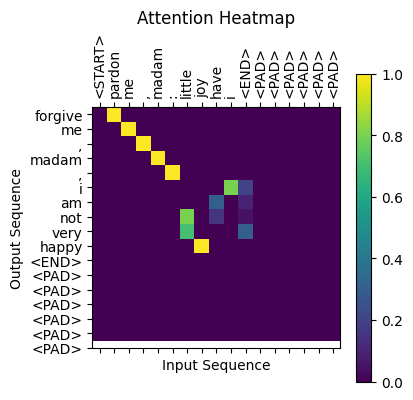

In [ ]:
# test attention plot
output_sequence = str.split(create_sentence(tf.reshape(a[13], (1, max_len)))[0])
input_sequence = str.split(create_sentence(tf.reshape(example_input_batch[13], (1, max_len)))[0])
visualize_attention(attention_weights, 0, input_sequence, output_sequence)

# Writer with similar style

In [ ]:
t_name = "Christopher Marlowe.txt"
t_path= F"/content/gdrive/My Drive/Database/{t_name}"

In [ ]:
text_data = []
with open(t_path, 'r') as file:
  for line in file:
    text_data.append(line.strip())

In [ ]:
# pre-process
import re

def preprocess_sentence(w):
        w = w.lower().strip()

        # creating a space between a word and the punctuation following it
        # eg: "he is a boy." => "he is a boy ."
        # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
        w = re.sub(r"([?.!,¿:])", r" \1 ", w)
        w = re.sub(r'[" "]+', " ", w)

        # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
        w = re.sub(r"[^a-zA-Z?.!,¿:']+", " ", w)

        w = w.strip()

        # adding a start and an end token to the sentence
        # so that the model know when to start and stop predicting.

        return w

In [ ]:
text = [preprocess_sentence(i) for i in text_data]

In [ ]:
# google-translate
!pip install googletrans==3.1.0a0

In [ ]:
# import libraries
import googletrans
from googletrans import Translator
import pandas as pd

translator = Translator()

def back_tranlate(w):
  translated_ita = translator.translate(w, src= 'en', dest= 'de')
  back= translator.translate(translated_ita.text, src= 'de', dest='en')
  return back.text